# This tutorial covers the basics of running MS2Deepscore
We will cover:
1. Calculating MS2Deepscore scores
2. Creating an MS2Deepscore molecular network
3. Calculating MS2Deepscore embeddings
4. Visualizing an MS2Deepscore UMAP representation

## Downloading model and dummy dataset

The model is downloaded from https://zenodo.org/records/13897744 this can also be done manually

You can of course also use your own spectrum file!

In [1]:
import requests
import os
from tqdm import tqdm

def download_file(link, file_name):
    response = requests.get(link, stream=True)
    if os.path.exists(file_name):
        print(f"The file {file_name} already exists, the file won't be downloaded")
        return
    total_size = int(response.headers.get('content-length', 0))
    
    with open(file_name, "wb") as f, tqdm(desc="Downloading file", total=total_size, unit='B', unit_scale=True, unit_divisor=1024,) as bar:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                bar.update(len(chunk))  # Update progress bar by the chunk size
    
model_file_name = "ms2deepscore_model.pt"
spectrum_file_name = "pesticides.mgf"
download_file("https://zenodo.org/records/13897744/files/settings.json?download=1", "ms2deepscore_settings.json")
download_file("https://zenodo.org/records/13897744/files/ms2deepscore_model.pt?download=1", model_file_name)
download_file("https://raw.githubusercontent.com/matchms/ms2deepscore/refs/heads/main/tests/resources/pesticides_processed.mgf", spectrum_file_name)

# 1. Calculating MS2Deepscore scores
MS2Deepscore predicts chemical similarity between mass spectra. It tries to approximate the tanimoto score, which is a metric for chemical similarity. As input the model requires MS2 spectra. These can be loaded in from any of the common file formats that matchms allows (e.g., mzml, mgf, msp, json etc)


In [2]:
from ms2deepscore.models import load_model

# load in the ms2deepscore model
model = load_model(model_file_name)


c:\users\jonge094\pycharmprojects\ms2deepscore\ms2deepscore\ms2deepscore\models\load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_settings = torch.load(f

The model version (2.0.0) does not match the version of MS2Deepscore (2.1.0), consider downloading a new model or changing the MS2Deepscore version


In [3]:
from matchms.Pipeline import Pipeline, create_workflow
from matchms.filtering.default_pipelines import DEFAULT_FILTERS
from ms2deepscore import MS2DeepScore

pipeline = Pipeline(create_workflow(query_filters=DEFAULT_FILTERS,
                                    score_computations=[[MS2DeepScore, {"model": model}]]))
report = pipeline.run(spectrum_file_name)
similarity_matrix = pipeline.scores.to_array()

2024-10-14 15:24:09,665:WARNING:matchms:Pipeline:The order of the filters has been changed compared to the Yaml file.
2024-10-14 15:24:09,667:WARNING:matchms:Pipeline:The order of the filters has been changed compared to the Yaml file.
2024-10-14 15:24:09,667:WARNING:matchms:Pipeline:No logging file was defined.Logging messages will not be written to file.


Processing spectra: 76it [00:01, 38.73it/s]
76it [00:01, 47.98it/s]


### Optional print a report for the spectrum cleaning by matchms. 

In [4]:
print(report)

----- Spectrum Processing Report -----
Number of spectra processed: 76
Number of spectra removed: 0
Changes during processing:
                              removed spectra  changed metadata  changed mass spectrum
filter                                                                                
add_retention_index                         0                76                      0
add_retention_time                          0                76                      0
clean_adduct                                0                76                      0
add_parent_mass                             0                76                      0
derive_formula_from_smiles                  0                76                      0
make_charge_int                             0                 0                      0
add_compound_name                           0                 0                      0
derive_adduct_from_name                     0                 0                      0
der

### The output is a matrix with all the scores between the spectra

In [5]:
# The size of the matrix
print(similarity_matrix.shape)

(76, 76)


In [6]:
print(similarity_matrix)

[[1.         0.48136784 0.38333452 ... 0.1129471  0.12154851 0.17609512]
 [0.48136784 1.         0.57624004 ... 0.31962144 0.33227743 0.25157794]
 [0.38333452 0.57624004 1.         ... 0.44612529 0.43256014 0.50354019]
 ...
 [0.1129471  0.31962144 0.44612529 ... 1.         0.96423773 0.44607427]
 [0.12154851 0.33227743 0.43256014 ... 0.96423773 1.         0.40574703]
 [0.17609512 0.25157794 0.50354019 ... 0.44607427 0.40574703 1.        ]]


# 2. Create a molecular network file
The calculated scores can be used to make a molecular network

In [7]:
from matchms.networking import SimilarityNetwork

# Define settings
ms2ds_network = SimilarityNetwork(
    identifier_key="spectrum_id", # This is the identifier used for the nodes. You might need to change this to for instance feature_id, scans etc. 
    score_cutoff=0.90,  # higher numbers produce more isolated sub-graphs
    max_links=5 ,  # lower number makes sparser networks
    link_method="mutual",  # mutual means: link is only added if in top list of both nodes
)

# Compute the graph (takes some time)
ms2ds_network.create_network(pipeline.scores, score_name="MS2DeepScore")
# Export to graphml
ms2ds_network.export_to_graphml("ms2ds_graph.graphml")

The graphml file can be loaded into cytoscape: for download see https://cytoscape.org/ This is an open source platform for visualizing graphs. 

To load in the data
- Open cytoscape
- Load in the above created graphml file.
- Load in a table with metadata that you want to overlay. For an example with ms2query annotations as table (see case_studies/add_annotations.ipynb)
- Set style settings (or load in a style file)
- Set up chemviz to visualize chemical information if you have annotations
- Explore your data!

# 3. Calculate embeddings
MS2Deepscore first converts spectra to embeddings, which are high dimensional vectors (500 dimensions). These embeddings are used for calculating the similarity score by calculating the [cosine distance](https://en.wikipedia.org/wiki/Cosine_similarity) between two embeddings. Embeddings can also been used directly to visualize the relative distance between spectra by using a dimensionality reduction method like UMAP.

In [8]:
cleaned_spectra = pipeline.spectra_queries

ms2ds_model = MS2DeepScore(model)
ms2ds_embeddings = ms2ds_model.get_embedding_array(cleaned_spectra)


76it [00:00, 142.96it/s]


This results in a matrix with the embeddings, it contains 76 embeddings with dimension 500.

In [9]:
ms2ds_embeddings.shape

(76, 500)

# 4. Visualize a ms2deepscore umap representation
Umap is a method for reducing multidimensional data to 2 dimensions. This is done in a way that aims to keep distances between embeddings close to the thruth. However, since reducing from 500 dementions some distortions always take place. Reducing to 2 dimensions allows us to visualize the embeddings.

The code below tries to learn how to best transform 500 dimensions to 2 dimensions.


In [10]:
import umap

reducer = umap.UMAP(random_state=42,  # this or whatever your favorite number is
                    n_neighbors=50 ,  # key parameters How global or local the distribution 30, 50
                    min_dist=0.2 , # can the dots overlap if you use 5 they move out a bit. 0.1, 0.2
                    )
reducer.fit(ms2ds_embeddings)

C:\Users\jonge094\AppData\Local\miniconda3\envs\pytorch\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0.2, n_neighbors=50, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})


### get 2d coordinates from embeddings
Here we use the fitted umap model to actually transform embeddings to a x and y coordinate


In [11]:
embedding_umap = reducer.transform(ms2ds_embeddings)

In [14]:
import pandas as pd
embedding_umap_df = pd.DataFrame(embedding_umap, 
                                 index = [spectrum.get("spectrum_id") for spectrum in cleaned_spectra],
                                columns = ["x", "y"])
# Add metadata to the table
embedding_umap_df["precursor_mz"] = [spectrum.get("precursor_mz") for spectrum in cleaned_spectra]
embedding_umap_df["smiles"] = [spectrum.get("smiles") for spectrum in cleaned_spectra]
embedding_umap_df

,x,y,precursor_mz,smiles
CCMSLIB00001058235,1.155417,8.516410,183.057,C1=CC=C2C(=C1)NC(=N2)C3=CC=CO3
CCMSLIB00001058238,0.379157,7.900370,208.146,CCCCC1=C(NC(=NC1=O)NCC)C
CCMSLIB00001058241,0.617763,7.225239,370.073,CC(C)(C)C(C(=CC1=C(C=C(C=C1)Cl)Cl)N2C=NC=N2)O
CCMSLIB00001058242,0.043208,8.382338,231.075,CN(C)C(=O)NC1=CC=CC(=C1)C(F)(F)F
CCMSLIB00001058245,0.242532,8.564999,246.044,C1=CC=C(C=C1)NC(=O)NC2=CC(=NC=C2)Cl
...,...,...,...,...
CCMSLIB00001058444,1.358423,4.128374,430.952,CCS(=O)C1=C(N(N=C1C#N)C2=C(C=C(C=C2Cl)C(F)(F)F...
CCMSLIB00001058449,1.806564,4.064288,434.931,C1=C(C=C(C(=C1Cl)N2C(=C(C(=N2)C#N)S(=O)C(F)(F)...
CCMSLIB00001058452,-0.409009,5.685254,681.016,CC1=CC=C(C=C1)C2=C(N=C(N2S(=O)(=O)N(C)C)C#N)Cl
CCMSLIB00001058458,-0.796274,5.357234,716.992,CC1=CC=C(C=C1)C2=C(N=C(N2S(=O)(=O)N(C)C)C#N)Cl


### Visualize the embeddings
The embeddings are visualized by using the x and y coordinate calculated from the embeddings using umap. You can color the nodes based on any of the available metadata, in the example we show coloring on precursor mz, but you could also use retention time or for instance predicted compound class. 

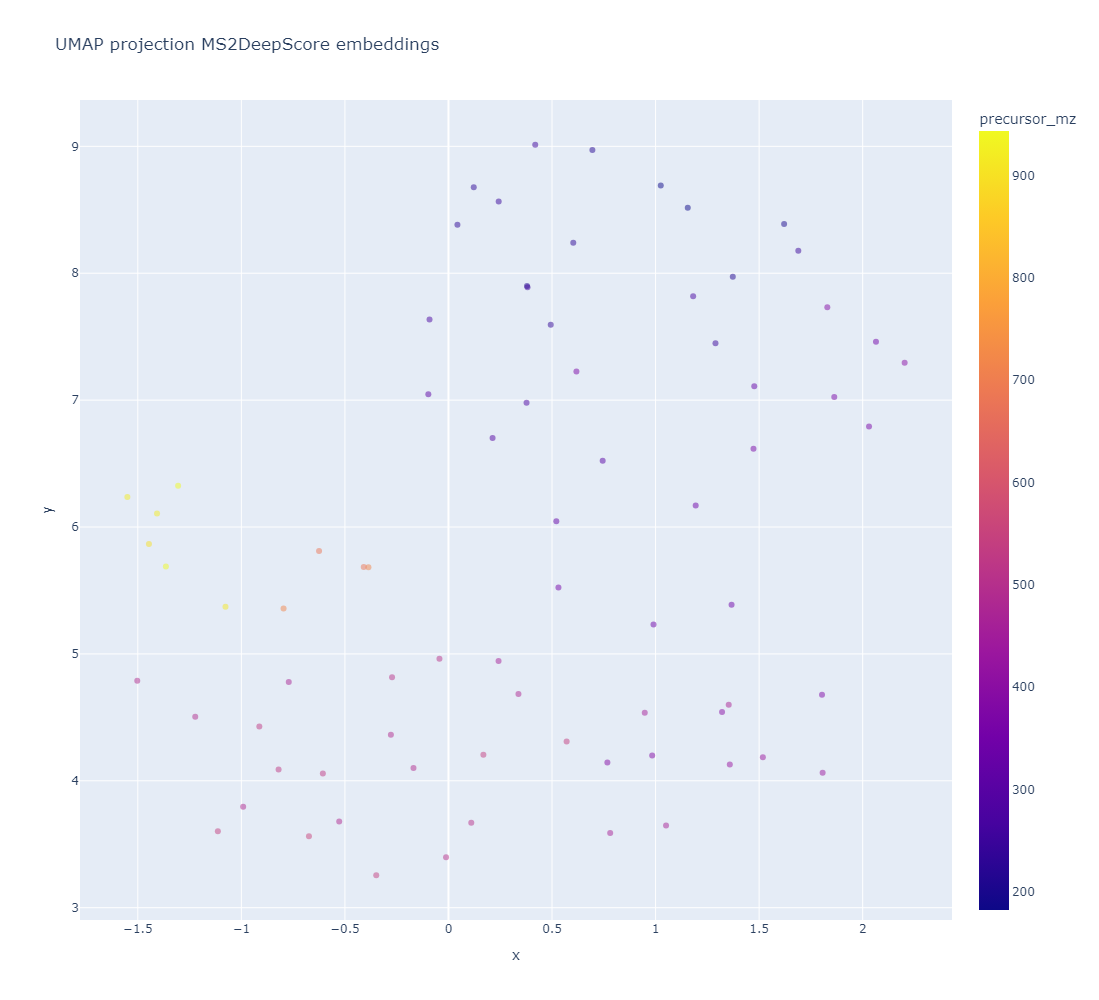

In [18]:
import plotly.express as px
import numpy as np

# Create scatter plot using Plotly Express
fig = px.scatter(embedding_umap_df,
    x="x",
    y="y",
    color="precursor_mz",
    size_max=50,
    opacity=0.5,
    title='UMAP projection MS2DeepScore embeddings',
    hover_data={"x": False,
                "y": False,
               "smiles": True,
               "precursor_mz": True},
    width=1000,
    height=1000,
)

fig.show()

### Add annotations to visualization
Visualizing just the embeddings is not very informative. To make the visualization helpfull it is good to overlay some additional information. 
You can show any metadata like retention time, ionisation mode, or precursor mz. But you can also visualize potential annotations. 

An example of adding annotations by using MS2Query is given in the case study notebooks. But the same principle can work with any other form of annotation. Since this is a MS2Deepscore tutorial, we will just use the manually added annotations added to this "pesticides" test set. 



In [32]:
port = 8700

In [56]:
import pandas as pd
import plotly.express as px

import molplotly

fig = px.scatter(embedding_umap_df,
    x="x",
    y="y",
    color="precursor_mz",
    width=1000,
    height=1000,
)

# add molecules to the plotly graph - returns a Dash app
app = molplotly.add_molecules(fig=fig,
                              df=embedding_umap_df,
                              smiles_col='smiles',
                              color_col="precursor_mz",
                              caption_cols=['precursor_mz'],
                              show_coords=False,
                            )

port += 1 # If you want to recreate a plot the port has to not be used before (this makes it easy to not forget increasing the port)

# run Dash app inline in notebook (or in an external server)
app.run_server(mode='inline', jupyter_mode="external", port=port, height=1000)

C:\Users\jonge094\AppData\Roaming\Python\Python39\site-packages\dash\dash.py:556: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



Dash app running on http://127.0.0.1:8723/
